In [28]:
import numpy as np
import pandas as pd
import geopandas as gp
import folium
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
housesedit = pd.read_csv('../Data/Cleaned/House/houseedit.csv', index_col='index')

In [3]:
housesedit.head(1)

,title,final_price,list_price,bedrooms,bathrooms,sqft,parking,description,mls,type,...,full_address,lat,long,city_district,mean_district_income,district_code,final_price_transformed,final_price_log,bedrooms_ag,bedrooms_bg
index,,,,,,,,,,,,,,,,,,,,,
0,"1303 - 38 Grenville St, Toronto (C4461599) | Z...",855000,870000,2 + 1 beds,2,850.0,1,"Luxurious And Spacious Murano Tower. 2+1, 2 Ba...",C4461599,Condo Apt,...,"38 Grenville St, Toronto , Ontario, Canada",43.661896,-79.385748,Bay Street Corridor,56526,76,2.391687,13.658857,2,1


In [4]:
housesedit.columns

Index(['title', 'final_price', 'list_price', 'bedrooms', 'bathrooms', 'sqft',
       'parking', 'description', 'mls', 'type', 'full_link', 'full_address',
       'lat', 'long', 'city_district', 'mean_district_income', 'district_code',
       'final_price_transformed', 'final_price_log', 'bedrooms_ag',
       'bedrooms_bg'],
      dtype='object')

In [5]:
housesedit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15234 entries, 0 to 17543
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    15234 non-null  object 
 1   final_price              15234 non-null  int64  
 2   list_price               15234 non-null  int64  
 3   bedrooms                 15234 non-null  object 
 4   bathrooms                15234 non-null  int64  
 5   sqft                     10713 non-null  float64
 6   parking                  15234 non-null  int64  
 7   description              15185 non-null  object 
 8   mls                      15234 non-null  object 
 9   type                     15234 non-null  object 
 10  full_link                15234 non-null  object 
 11  full_address             15234 non-null  object 
 12  lat                      15234 non-null  float64
 13  long                     15234 non-null  float64
 14  city_district         

In [6]:
num_columns = ['bathrooms','sqft', 'parking', 'mean_district_income',
           'bedrooms_ag', 'bedrooms_bg','final_price']

Correlation between numerical columns

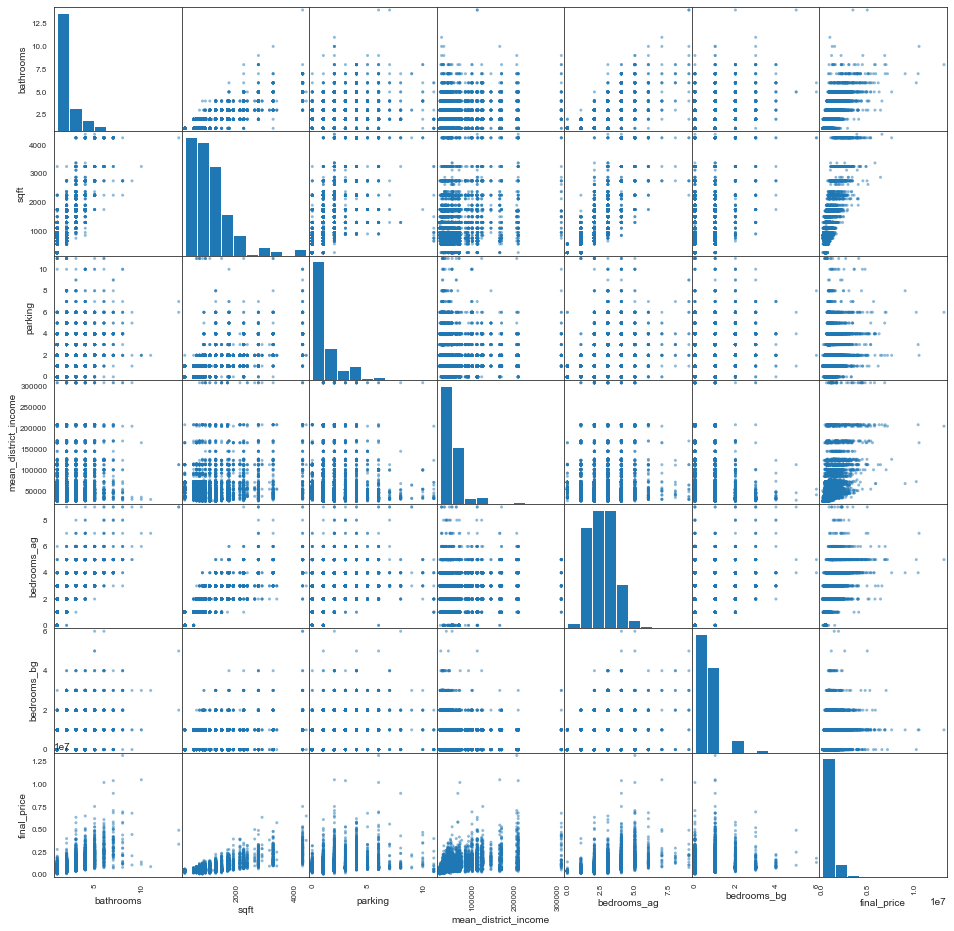

In [30]:
from pandas.plotting import scatter_matrix

sns.set_style('white')

scatter_matrix(housesedit[num_columns], figsize = (16,16))

plt.show()

In [8]:
#import pandas_profiling

#housesedit.profile_report()

### Can be done later

In [9]:
#housesedit.plot(kind = 'scatter', x = 'long', y = 'lat', alpha = 0.4, figsize = (15,7),c = 'final_price_log', cmap = plt.get_cmap('jet'), colorbar = True)

---

#### Missing Values

From the data below it is clear that we are missing **~30% of SQFT values**  

In [10]:
round((housesedit.isna().sum()/ len(housesedit)) *100,3).sort_values(ascending=False).head()

sqft           29.677
description     0.322
bedrooms_bg     0.000
type            0.000
final_price     0.000
dtype: float64

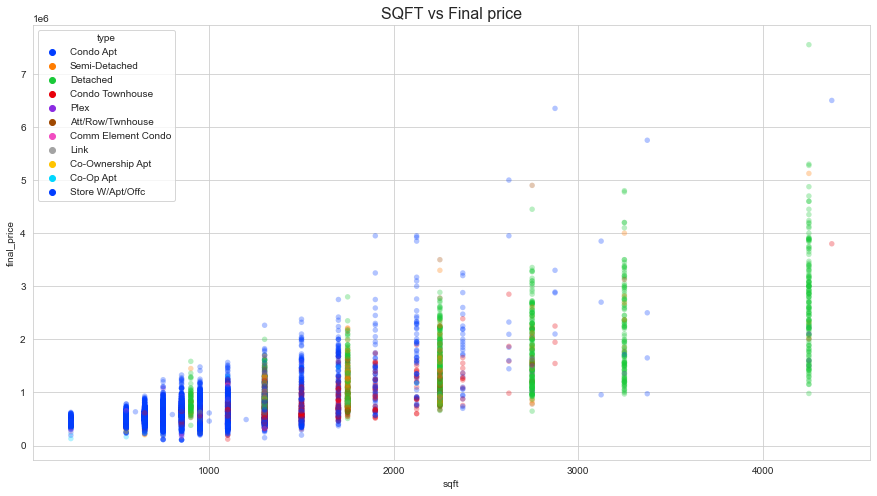

In [37]:
sns.set_style("whitegrid")
plt.figure(figsize=[15,8])
sns.scatterplot(x='sqft', y='final_price' ,data=housesedit, 
                hue = housesedit.type,linewidth=0, alpha=0.3, palette='bright', s=30)
plt.title('SQFT vs Final price', fontsize=16)
plt.show()

---
#### Feature Importance

In [11]:
from sklearn.tree import DecisionTreeRegressor

columns = ['bathrooms','sqft', 'parking', 'type','mean_district_income',
           'bedrooms_ag', 'bedrooms_bg','final_price']

pred_dummy = pd.get_dummies(housesedit[columns])

predictors = pred_dummy.drop('final_price', axis=1).columns

df = pred_dummy.dropna(subset=['sqft'])

model = DecisionTreeRegressor(criterion='mae')

model.fit(df[predictors],df.final_price)

sorted_feature_importance = sorted(zip(model.feature_importances_, df[predictors].columns))

x = [a[0] for a in sorted_feature_importance]
y = [a[1] for a in sorted_feature_importance]

plt.scatter(x,y)
plt.title('Feature Importances')
plt.show()

*From the above figure it is clear that **'SQFT'** is a important feature and 
we need to impute values where it is null*

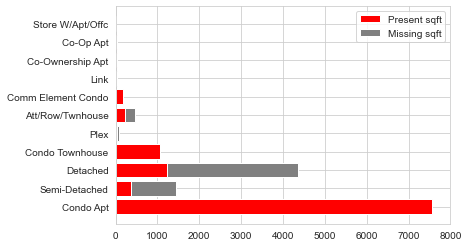

In [31]:
house_na = list()
house_not_na = list()

house_types = pd.unique(housesedit.type)

for house_type in house_types:
    house_na.append(sum((housesedit.type == house_type) & (pd.isna(housesedit.sqft))))
    house_not_na.append(sum((housesedit.type == house_type) & (pd.notna(housesedit.sqft))))
    

index = np.arange(house_types.shape[0])


width = 0.5

sns.set_style('whitegrid')
plt.barh(index, house_not_na, color='red')
plt.barh(index, house_na, left=house_not_na, color='grey')

plt.xlim([0,8000])
plt.legend(['Present sqft', 'Missing sqft'])
plt.yticks(index, house_types)
plt.show()

We can see that **SQFT** is mostly missing for Detached and Semi-Detached houses

---
Let's impute the missing data in SQFT

#### Custom Imputer

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor

class sqft_impute(BaseEstimator, TransformerMixin):
    
    def __init__(self, how='mean'):
        self.how = how
    
    def fit(self, dataset, y=None):
        return self
    
    def transform(self, dataset):
            
        dummy = dataset.copy()
        
        if self.how == 'mean':
            dummy['sqft'] = housesedit.groupby(by='type')['sqft'].transform(lambda x: x.fillna(x.mean(skipna=True)))
        
        if self.how == 'random':
            train_x = pred_dummy.dropna(subset=['sqft']).drop(columns=['sqft'])
            train_y = pred_dummy.dropna(subset=['sqft'])['sqft']
            test_x = pred_dummy[pd.isna(pred_dummy.sqft)].drop(columns=['sqft'])

            random_forest = RandomForestRegressor()
            random_forest.fit(train_x, train_y)
            test_y = random_forest.predict(test_x)
            dummy.loc[test_x.index,'sqft'] = test_y
            
        return dummy[predictors]

imputer = sqft_impute('random')

house_non_na = imputer.fit_transform(pred_dummy[predictors])